In [45]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [19]:
sess = None

def reset_tf():
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()
    
reset_tf()

In addition to constants and placeholders, TensorFlow also has **Variables**. They can be updated during a computation.

Note that variables must be initialized before they are run. Use global_variables_initializer().

In [20]:
var = tf.Variable(3, name="my_var", dtype=np.int32)

In [21]:
init = tf.global_variables_initializer()
sess.run(init)
sess.run(var)

3

Since we use global variable initializer so much, make a helper function:

In [22]:
def reset_vars():
    sess.run(tf.global_variables_initializer())

In [24]:
rand_var = tf.Variable(tf.random_normal([2,2], stddev=1, mean=2))
reset_vars()
print(sess.run(rand_var))

[[ 2.62214494  2.69133568]
 [ 1.52778268  2.4491353 ]]


In [25]:
change_var = var.assign(5)

In [26]:
print(sess.run(var))
print(sess.run(change_var))
print(sess.run(var))

3
5
5


In [27]:
double_var = var.assign(var * 2)
print(sess.run(double_var))
print(sess.run(double_var))

10
20


Value of a variable exists only within a session:

In [29]:
sess2 = tf.Session()
sess2.run(tf.global_variables_initializer())
print("New session:", sess2.run(var))
print("Old session:", sess.run(var))

New session: 3
Old session: 20


## Newton's Method

$$ f(x) \approx f(x_0) + f'(x_0) (x - x_0) $$

$$ x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)} $$

Consider $f(x) = x^2 - 2$  
The roots are $x = \pm\sqrt2$

In [34]:
reset_tf()

x = tf.Variable(0.05, name="root", dtype=np.float64)

In [35]:
f = x * x - 2
fp = 2 * x

In [36]:
iterate = x.assign(x - f / fp)

In [38]:
reset_vars()

for i in range(10):
    print(sess.run(iterate))

20.025
10.062437578
5.13059828749
2.76020818631
1.74239560615
1.44512027882
1.41454406259
1.41421360098
1.41421356237
1.41421356237


In [39]:
sess.run(x) - np.sqrt(2)

0.0

#### Use tf.gradients() to take derivatives

In [40]:
fp_auto = tf.gradients(f, x)[0]

In [42]:
iterate_auto = x.assign(x - f / fp_auto)
reset_vars()
for i in range(10):
    print(sess.run(iterate_auto))

20.025
10.062437578
5.13059828749
2.76020818631
1.74239560615
1.44512027882
1.41454406259
1.41421360098
1.41421356237
1.41421356237


#### Similarly, to find the minima of functions (where derivative is zero):

Approximate:

$$ f'(x) \approx f'(x_0) + f''(x_0) (x - x_0) $$

Leads to the update rule:

$$ x_{n+1} = x_n - \frac{f'(x_n)}{f''(x_n)} $$

In [ ]:
Consider the gamma function:

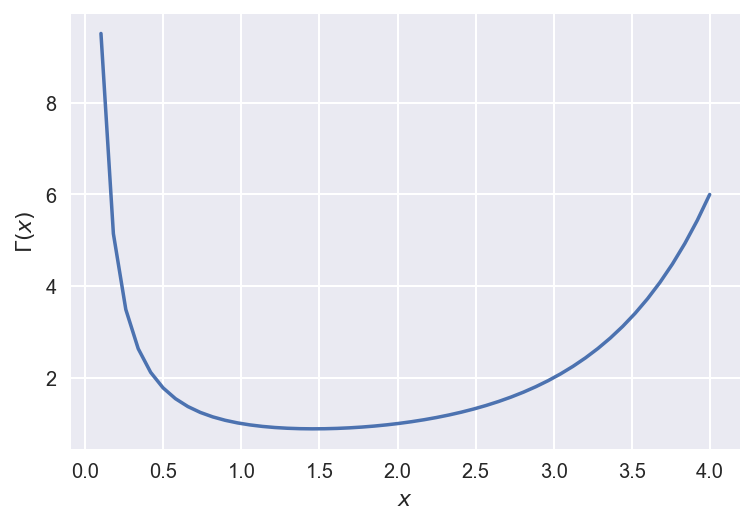

In [46]:
xx = np.linspace(0.1,4)
plt.plot(xx, sess.run(tf.exp(tf.lgamma(xx))))
plt.xlabel('$x$')
plt.ylabel(r'$\Gamma(x)$');
plt.show()

In [49]:
reset_tf()

x = tf.Variable(3, name="root", dtype=np.float64)
f = tf.exp(tf.lgamma(x))
fp_auto = tf.gradients(f, x)[0]
fp2_auto = tf.gradients(fp_auto, x)[0]
iterate_auto = x.assign(x - fp_auto / fp2_auto)

reset_vars()

for i in range(10):
    print(sess.run(iterate_auto))

2.25967890146
1.60915629226
1.45526617044
1.46161332349
1.46163214481
1.46163214497
1.46163214497
1.46163214497
1.46163214497
1.46163214497


#### Functions of multiple arguments

Equivalent expansion in terms of gradients:
$$ \nabla f(\mathbf x) \approx \nabla f'(\mathbf {x_0}) + (\mathbf{x} - \mathbf{x_0})\cdot \nabla\ \nabla f(\mathbf{x_0}) $$

Setting all components of this equation to zero leads to n equations for the n components of x:


If $\mathbf{x} = (x, y)$, we can do a bit of math to find the update rules

$$ x_{n+1} = x_n + \left. \left( \frac{\partial^2 f}{\partial x \partial y}\frac{\partial f}{\partial y} - \frac{\partial^2 f}{\partial y^2}\frac{\partial f}{\partial x} \right) \middle/ \left( \frac{\partial^2 f}{\partial x^2} \frac{\partial^2 f}{\partial y^2} - \left(\frac{\partial^2 f}{\partial x \partial y}\right)^2 \right)\right. $$

$$ y_{n+1} = y_n + \left. \left( \frac{\partial^2 f}{\partial x \partial y}\frac{\partial f}{\partial x} - \frac{\partial^2 f}{\partial x^2}\frac{\partial f}{\partial y} \right) \middle/ \left( \frac{\partial^2 f}{\partial x^2} \frac{\partial^2 f}{\partial y^2} - \left(\frac{\partial^2 f}{\partial x \partial y}\right)^2 \right)\right. $$

Use these to find the minimum of the function

$$ f(x, y) = x\,y - 0.5x \log(y) - y \log(x) - \log(2x + y) $$

In [50]:
reset_tf()

start = np.round(np.linspace(0,2,20),2)
for i in start:
    x = tf.Variable(i, name="root", dtype=np.float64)
    y = tf.Variable(i, name="root", dtype=np.float64)
    f = x*y - 0.5*x*tf.log(y) - y*tf.log(x) - tf.log(2*x+y)
    dfdx = tf.gradients(f, x)[0]  
    dfdy = tf.gradients(f, y)[0]  
    dfdx2 = tf.gradients(dfdx, x)[0]  
    dfdy2 = tf.gradients(dfdy, y)[0]  
    dfdxdy = tf.gradients(dfdx, y)[0]  
    iterate_x = x.assign(x + (dfdxdy * dfdy - dfdy2 * dfdx) / (dfdx2 * dfdy2 - dfdxdy**2))
    iterate_y = y.assign(y + (dfdxdy * dfdx - dfdx2 * dfdy) / (dfdx2 * dfdy2 - dfdxdy**2))
    
    reset_vars()
    
    for j in range(50):
        sess.run(iterate_x), sess.run(iterate_y)
    
    print(i, sess.run(x), sess.run(y))

0.0 nan nan
0.11 1.7830666414 0.908566005259
0.21 1.7830666414 0.908566005259
0.32 1.7830666414 0.908566005259
0.42 1.7830666414 0.908566005259
0.53 1.7830666414 0.908566005259
0.63 1.7830666414 0.908566005259
0.74 1.7830666414 0.908566005259
0.84 1.7830666414 0.908566005259
0.95 1.7830666414 0.908566005259
1.05 1.7830666414 0.908566005259
1.16 1.7830666414 0.908566005259
1.26 1.7830666414 0.908566005259
1.37 1.7830666414 0.908566005259
1.47 1.7830666414 0.908566005259
1.58 1.7830666414 0.908566005259
1.68 nan nan
1.79 nan nan
1.89 nan nan
2.0 nan nan
